### Convolution Neural Net

#### We should have enough to put together a cnn now.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# predefine some hyper parameter
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range[0, 1], we transform them to tensors of formalized range of [-1, 1]
my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

Not sure why we are normalizing to mean and std of 0.5, instead of 0; need to investigate.

In [4]:
?transforms.Normalize

Now we get some data.

In [14]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=my_transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=my_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let's see some sample images, and get our dimensions/shape needed in the middle of the neural net.   
Note width or height after one round of kernel and strides:

`(w - f + 2*p) / s + 1`

w: width (or height)  
f: kernel or filter size  
p: padding size, 0 if no padding  
s: stride  

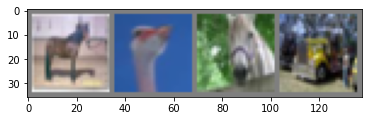

torch.Size([4, 3, 32, 32])

In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# hard code some layer to confirm layer dimensions
conv1 = nn.Conv2d(3, 6, 5)  # in_channel, out_channel, kernel_size
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
images.shape  # (batch_size, number color channel, width, height)

In [7]:
x = conv1(images)
x.shape  # (batch_size, num channel?, width after stride and pooling?, height after stride and pooling?)

torch.Size([4, 6, 28, 28])

In [8]:
x = pool(x)
x.shape

torch.Size([4, 6, 14, 14])

In [9]:
x = conv2(x)
x.shape

torch.Size([4, 16, 10, 10])

In [11]:
# Implement the Conv net, and get the key components like the loss function and optimizer.

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # kernel size, stride size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # first round of convulution
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # second round of convulution
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # then we flatten the matrix before we can pass to fully connected layers
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # again no softmax as the last layer, since we are using CrossEntropyLoss(), which does
        # it for us. Personally I think this is a bad, it goes against the principles of being
        # explicit
        
        return x
        
    
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()  # the usual, for multi-label classification
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Hard coded training loop:

In [12]:
n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # original shape: [4, 3, 32, 32] = 4, 3,  1024 
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward and optimize weight
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            
print(f'Finished training')

Epoch [1/5], Step [1000/12500], Loss: 2.3084
Epoch [1/5], Step [2000/12500], Loss: 2.3243
Epoch [1/5], Step [3000/12500], Loss: 2.3131
Epoch [1/5], Step [4000/12500], Loss: 2.2804
Epoch [1/5], Step [5000/12500], Loss: 2.3059
Epoch [1/5], Step [6000/12500], Loss: 2.2498
Epoch [1/5], Step [7000/12500], Loss: 2.2274
Epoch [1/5], Step [8000/12500], Loss: 2.2030
Epoch [1/5], Step [9000/12500], Loss: 2.3401
Epoch [1/5], Step [10000/12500], Loss: 2.0783
Epoch [1/5], Step [11000/12500], Loss: 2.2352
Epoch [1/5], Step [12000/12500], Loss: 1.6574
Epoch [2/5], Step [1000/12500], Loss: 1.7923
Epoch [2/5], Step [2000/12500], Loss: 2.5545
Epoch [2/5], Step [3000/12500], Loss: 1.8594
Epoch [2/5], Step [4000/12500], Loss: 1.4155
Epoch [2/5], Step [5000/12500], Loss: 1.6305
Epoch [2/5], Step [6000/12500], Loss: 2.3296
Epoch [2/5], Step [7000/12500], Loss: 2.5136
Epoch [2/5], Step [8000/12500], Loss: 1.7557
Epoch [2/5], Step [9000/12500], Loss: 1.8022
Epoch [2/5], Step [10000/12500], Loss: 0.8905
Epoch 

Simple Analysis:

In [15]:
# remember to torch.no_grad() as we don't want these calculation to go into the computation graph

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc}%')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc}%')

Accuracy of the network: 48.14%
Accuracy of plane: 43.2%
Accuracy of car: 67.4%
Accuracy of bird: 24.7%
Accuracy of cat: 26.6%
Accuracy of deer: 34.9%
Accuracy of dog: 41.4%
Accuracy of frog: 51.4%
Accuracy of horse: 68.9%
Accuracy of ship: 57.8%
Accuracy of truck: 65.1%
